C:\Users\bs23037\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN-LSTM...
Epoch 1/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8016 - loss: 0.6742 - val_accuracy: 0.9541 - val_loss: 0.1837
Epoch 2/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9628 - loss: 0.1481 - val_accuracy: 0.9780 - val_loss: 0.0857
Epoch 3/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9767 - loss: 0.0889 - val_accuracy: 0.9778 - val_loss: 0.0814
Epoch 4/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9795 - loss: 0.0763 - val_accuracy: 0.9835 - val_loss: 0.0600
Epoch 5/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9842 - loss: 0.0581 - val_accuracy: 0.9827 - val_loss: 0.0597
Epoch 6/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9866 - loss: 0.0491 - val_accuracy: 0.9868 - val_loss: 0.0513
Epoch 7/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9881 - loss: 0.0442 - val_accuracy: 0.9876 - val_loss: 0.0420
Epoch 8/14
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9

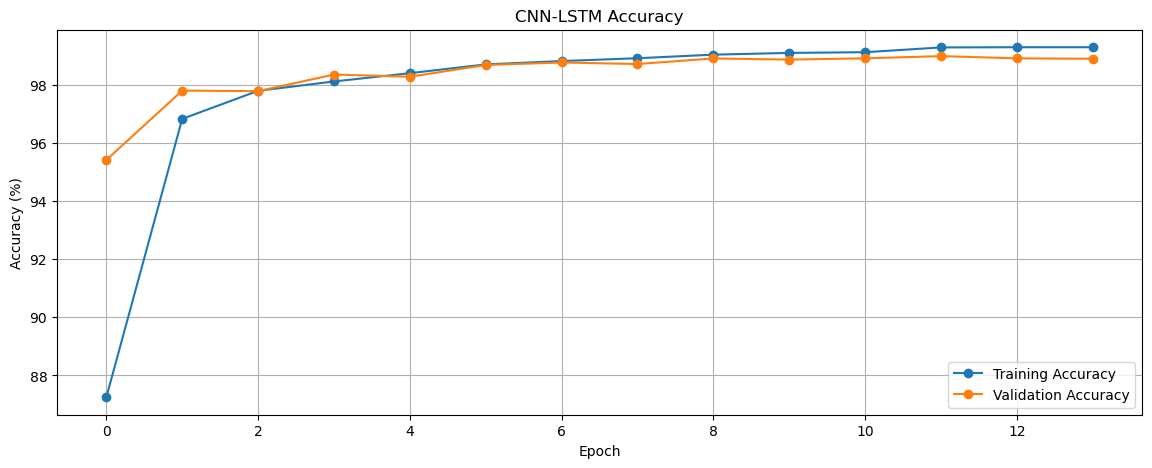

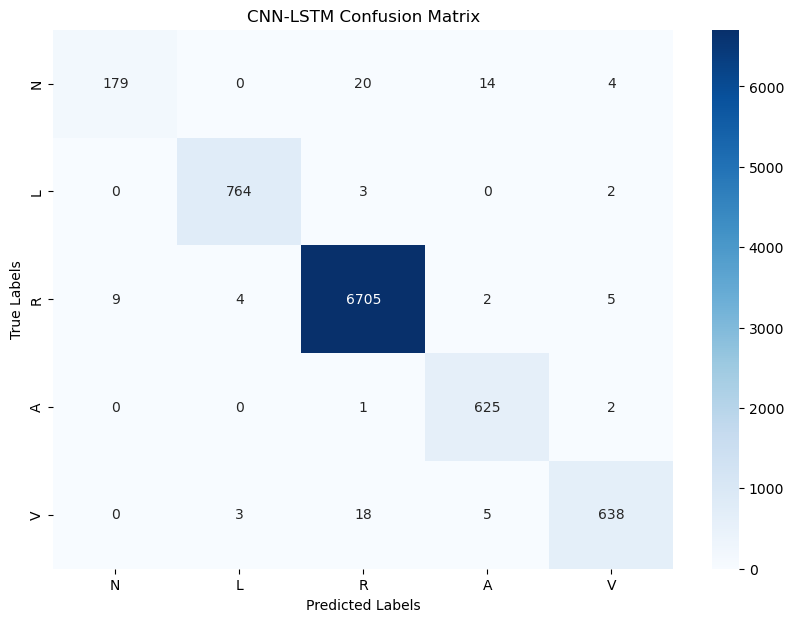

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define the path to the extracted dataset
data_path = 'M:\Dissertation\mit-bih-arrhythmia-database-1.0.0-20240722T094228Z-001\mit-bih-arrhythmia-database-1.0.0'

# Function to load a record and preprocess
def load_and_preprocess(record):
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
    
    # Use only one channel (e.g., channel 0)
    signal = signal[:, 0].reshape(-1, 1)
    
    # Segment the signal
    segments = []
    labels = []
    for i in range(len(annotation.sample)):
        if annotation.sample[i] - 99 > 0 and annotation.sample[i] + 160 < len(signal):
            segments.append(signal[annotation.sample[i] - 99 : annotation.sample[i] + 161])
            labels.append(annotation.symbol[i])
    
    return np.array(segments), np.array(labels)

# Function to load and preprocess all records in the dataset
def load_and_preprocess_all_records(data_path):
    all_segments = []
    all_labels = []
    
    for record in os.listdir(data_path):
        if record.endswith('.dat'):
            record_name = record[:-4]  # Remove the file extension
            segments, labels = load_and_preprocess(record_name)
            all_segments.append(segments)
            all_labels.append(labels)
    
    # Concatenate all segments and labels
    all_segments = np.vstack(all_segments)
    all_labels = np.concatenate(all_labels)
    
    return all_segments, all_labels

# Load and preprocess the entire dataset
segments, labels = load_and_preprocess_all_records(data_path)

# Filter out unwanted labels (keeping only certain labels, e.g., 'N', 'L', 'R', 'A', 'V')
valid_labels = ['N', 'L', 'R', 'A', 'V']
mask = np.isin(labels, valid_labels)
segments = segments[mask]
labels = labels[mask]

# Reshape segments to fit the model's expected input shape for CNN
segments = segments.reshape(segments.shape[0], segments.shape[1], 1, 1)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to categorical format
labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(segments, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# CNN-LSTM Model
def create_cnn_lstm(input_shape, num_classes):
    model = Sequential([
        # CNN part (from the highest accuracy CNN model)
        Conv2D(32, (5, 1), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 1)),
        Conv2D(64, (3, 1), activation='relu'),
        MaxPooling2D((2, 1)),
        Conv2D(128, (5, 1), activation='relu'),
        MaxPooling2D((2, 1)),
        Conv2D(256, (3, 1), activation='relu'),
        MaxPooling2D((2, 1)),
        
        # Reshape for LSTM input
        Reshape((13, 256)),  # Adjusting the shape for LSTM input
        
        # LSTM part
        LSTM(32, return_sequences=False),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape based on your data
input_shape = (segments.shape[1], 1, 1)  # (timesteps, features, 1) for CNN

# Number of classes (based on the number of valid labels)
num_classes = len(valid_labels)

# Create the CNN-LSTM model
cnn_lstm_model = create_cnn_lstm(input_shape, num_classes)

# Train the model and evaluate
print(f'Training CNN-LSTM...')
start_time = time.time()

# Train the model
history = cnn_lstm_model.fit(X_train, y_train, epochs=14, validation_data=(X_val, y_val), batch_size=128)

# Calculate the total training time
total_training_time = time.time() - start_time

# Predict on the test data
y_pred = cnn_lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Compute the metrics
overall_accuracy = np.sum(y_pred_classes == y_test_classes) / len(y_test_classes)
overall_sensitivity = recall_score(y_test_classes, y_pred_classes, average='macro') * 100
overall_specificity = (conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])) * 100 if conf_matrix.shape[0] > 1 else 0
overall_precision = precision_score(y_test_classes, y_pred_classes, average='macro') * 100
overall_fscore = f1_score(y_test_classes, y_pred_classes, average='macro') * 100

# Print the results
print(f"Results for CNN-LSTM:")
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Overall Sensitivity: {overall_sensitivity:.2f}%")
print(f"Overall Specificity: {overall_specificity:.2f}%")
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall F-Score: {overall_fscore:.2f}%")

# Plot training & validation accuracy values (as percentage)
plt.figure(figsize=(14, 5))
plt.plot(np.array(history.history['accuracy']) * 100, 'o-')
plt.plot(np.array(history.history['val_accuracy']) * 100, 'o-')
plt.title(f'CNN-LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels, yticklabels=valid_labels)
plt.title(f'CNN-LSTM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
